# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
from IPython.display import HTML, clear_output, display
from IPython.display import Image as IPythonImage
%reload_ext autoreload
%autoreload 2

# Imports

In [ ]:
#| export 
import torch
from torch import autocast
from torchvision import transforms as tfms

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging

from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import (
    EulerAncestralDiscreteScheduler, 
    LMSDiscreteScheduler
)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import (
    StableDiffusionPipelineOutput, 
    StableDiffusionPipeline,
)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

import os
import io
import inspect
import requests
import random
from tqdm.auto import tqdm
import PIL
from matplotlib import pyplot as plt
import numpy as np
import base64
from typing import List, Union, Tuple, Dict, Any
from pprint import pprint
import tempfile

# serving
import pydantic

logging.set_verbosity_error()

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    # https://huggingface.co/docs/diffusers/optimization/mps
    device = "mps"
else:
    device = "cpu"
  

# Global variables

In [ ]:
#| export
HF_SD_MODEL = "runwayml/stable-diffusion-v1-5"
HF_CLIP_MODEL = "openai/clip-vit-large-patch14"

VAE_ENCODE_SCALE = 0.18215
VAE_DECODE_SCALE = 1 / VAE_ENCODE_SCALE

## API

In [ ]:
#| export
# CUSTOM_PARAMS_START = "custom_params_start"

# Initialization

## schedulers

In [ ]:
#| export
lms_scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear", 
    num_train_timesteps=1000
)

euler_a_scheduler = EulerAncestralDiscreteScheduler.from_config(
    HF_SD_MODEL, subfolder="scheduler"
)

In [ ]:
#| export
SCHEDULERS = {
    "euler_a": euler_a_scheduler,
    "lms": lms_scheduler,
}

DEFAULT_SCHEDULER = euler_a_scheduler

## text2image pipe w/ fp16 & optim.

In [ ]:
#| export
if device == "mps":
    pipe = StableDiffusionPipeline.from_pretrained(
        HF_SD_MODEL, 
        scheduler=DEFAULT_SCHEDULER
    )
else:
    pipe = StableDiffusionPipeline.from_pretrained(
        HF_SD_MODEL, 
        torch_dtype=torch.float16, 
        revision="fp16",
        scheduler=DEFAULT_SCHEDULER
    )

pipe.safety_checker = None
pipe.to(device)
# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_attention_slicing()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

## main components in pipe

In [ ]:
#| export
vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet
scheduler = pipe.scheduler
generator = torch.Generator()

## additional pipes

### i2i_pipe

- https://github.com/huggingface/diffusers/blob/main/docs/source/api/pipelines/overview.mdx#-diffusers-summary

In [ ]:
#| export
i2i_pipe = StableDiffusionImg2ImgPipeline(**pipe.components)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/6 [00:00<?, ?it/s]

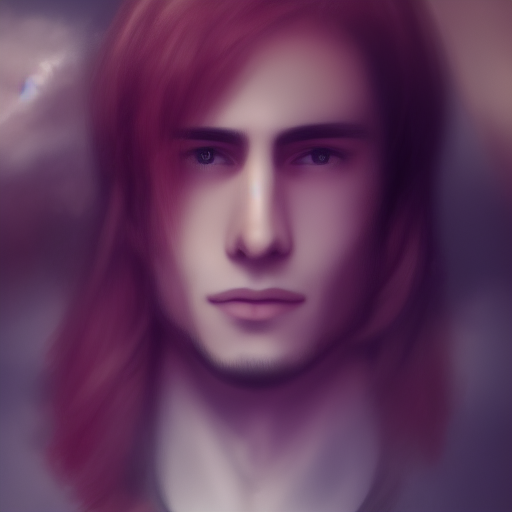

In [ ]:
#| server
torch.manual_seed(1627137983322845203)
img = PIL.Image.open("images/test_image.png")
pipe_out = i2i_pipe("handsome boy", init_image=img, num_inference_steps=10, strength=0.6)
pipe_out.images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

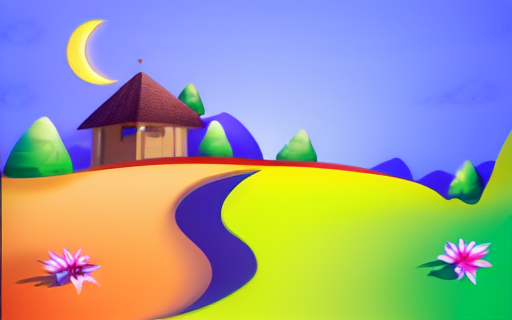

In [ ]:
#| server
torch.manual_seed(16931923490033927181)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_img = PIL.Image.open(io.BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((512, 336))
prompt = "A fantasy landscape"

with autocast("cuda"):
    pipe_out = i2i_pipe(prompt=prompt, 
                        init_image=init_img, 
                        num_inference_steps=50,
                        strength=0.8, 
                        guidance_scale=7.5)

pipe_out.images[0]

# Helpers

## pil_to_latents

In [ ]:
#| export
@torch.no_grad()
def pil_to_latents(im: PIL.Image.Image) -> torch.Tensor:
    """
    Transform single image into single latent in a batch w/ shape = (1, 4, 64, 64)
    """
    device = vae.device.type
    tensor = tfms.ToTensor()(im).unsqueeze(0).to(device)
    tensor = tensor * 2 - 1
    with torch.autocast(device):
        latent = vae.encode(tensor) 
    torch.cuda.empty_cache()
    
    return VAE_ENCODE_SCALE * latent.latent_dist.sample()

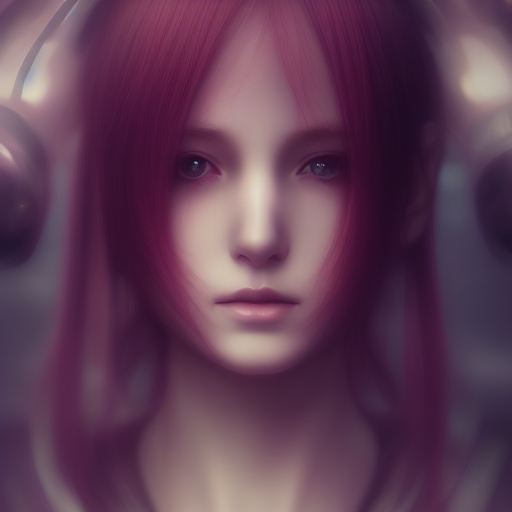

latents.shape: torch.Size([1, 4, 64, 64])


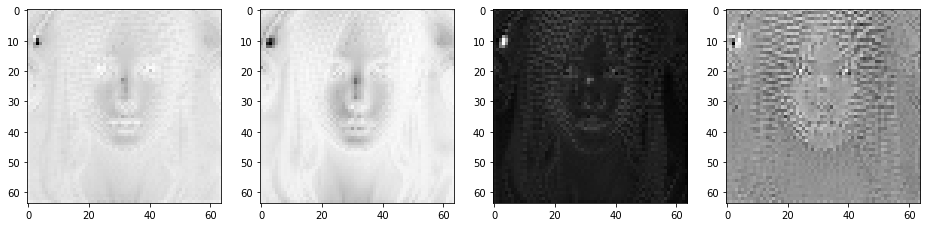

In [ ]:
#| server
im = PIL.Image.open("images/test_image.png")
display(im)
latents = pil_to_latents(im)
print(f"latents.shape: {latents.shape}")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latents[0][c].cpu(), cmap='Greys')

## latents_to_pils

In [ ]:
#| export
@torch.no_grad()
def latents_to_pils(
    latents: Union[torch.Tensor, List[torch.Tensor]], 
    batch_size=4
) -> List[PIL.Image.Image]:
    """
    Transform batch of latent back to list of pil images
    - latents: shape(#latents, channels, heights, width)
    """
    
    device = vae.device.type
    if type(latents) is list:
        latents = torch.concat(latents)
        
    shape = latents.shape
    assert len(shape) == 4  # (b, c, h, w)
    
    n = latents.shape[0]
    print(f"generating {n} pil images from latents.")
    num_chunks = int(np.ceil(n / batch_size))
    chunks: Tuple[torch.Tensor] = torch.chunk(latents, num_chunks)
    
    pil_ims = []
    
    for latents in tqdm(chunks):
        latents = latents.to(device)  # (b, c, h, w)
        latents = VAE_DECODE_SCALE * latents
    
        with torch.autocast(device):
            ims = vae.decode(latents).sample
        
        ims = (ims / 2 + 0.5).clamp(0, 1)
        ims = ims.detach().cpu().permute(0, 2, 3, 1).numpy()
        ims = (ims * 255).round().astype("uint8")
        
        torch.cuda.empty_cache()
        pil_ims.extend([PIL.Image.fromarray(im) for im in ims])
    
    return pil_ims

torch.Size([6, 4, 64, 64])
generating 6 pil images from latents.


  0%|          | 0/2 [00:00<?, ?it/s]

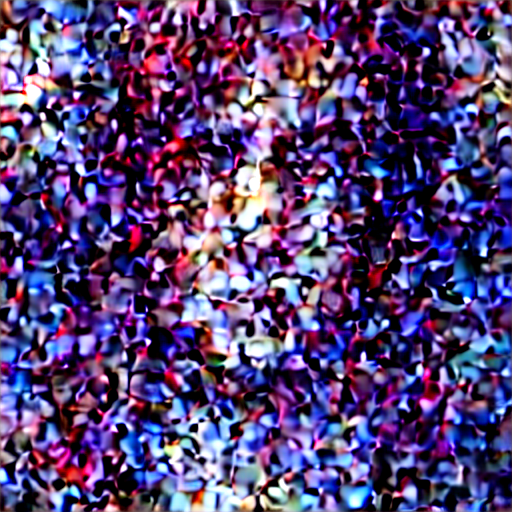

In [ ]:
#| server
print(latents.shape)
ims = latents_to_pils(latents)
ims[0]

## generate_image_grid

In [ ]:
#| export
def generate_image_grid(
    images: List[PIL.Image.Image], 
    nrow: int, 
    ncol: int):

    w, h = images[0].size # assume all images are of the same size
    grid = PIL.Image.new('RGB', size=(ncol * w, nrow * h))
    for i, im in enumerate(images): 
        grid.paste(im, box=(i % ncol * w, i // ncol * h))
    return grid

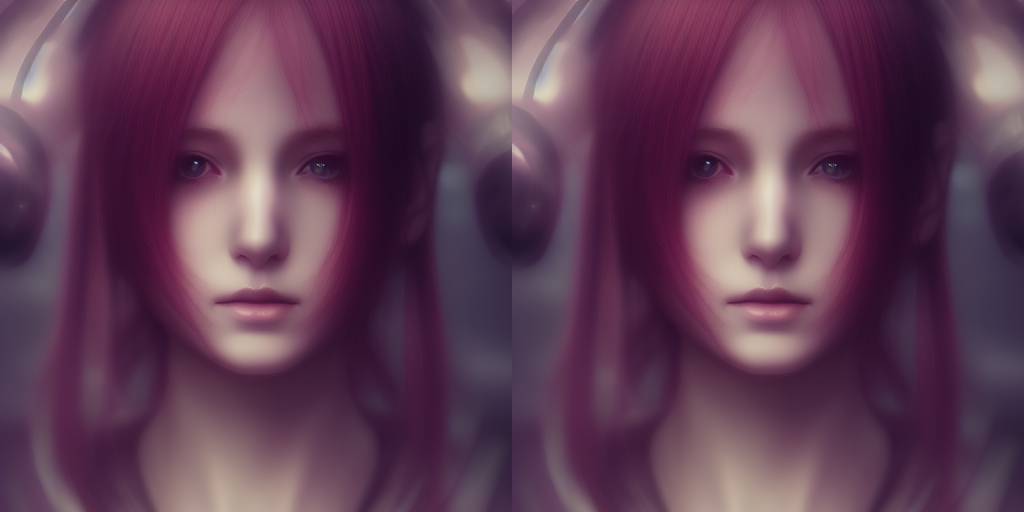

In [ ]:
#| server
image = PIL.Image.open("images/test_image.png")
grid = generate_image_grid([image] * 2, 1, 2)
grid

## get_image_size_from_aspect_ratio

In [ ]:
#| export
def get_image_size_from_aspect_ratio(aspect_ratio: float) -> Tuple[int, int]:
    base = 512
    width, height = (base, base)
    
    if aspect_ratio == 1:
        pass
    elif aspect_ratio < 1:
        height = base
        raw_width = round(height * aspect_ratio)
        multiplier = raw_width // 8
        width = 8 * multiplier
    elif aspect_ratio > 1:
        width = base
        raw_height = round(width / aspect_ratio)
        multiplier = raw_height // 8
        height = 8 * multiplier
    
    return (width, height)

In [ ]:
#| server
aspect_ratio = 0.6
width, height = get_image_size_from_aspect_ratio(aspect_ratio)
width, height

(304, 512)

## pil_to_b64

In [ ]:
#| export
def pil_to_b64(im: PIL.Image.Image, format="PNG") -> str:
    buffered = io.BytesIO()
    im.save(buffered, format=format)
    im_str = base64.b64encode(buffered.getvalue())
    return im_str.decode()

## b64_to_pil

In [ ]:
#| export
def b64_to_pil(b64: str, format="PNG") -> PIL.Image.Image:
    im = PIL.Image.open(io.BytesIO(base64.b64decode(b64)))
    try:
        im = im.convert(format)
    except ValueError:
        im = im.convert("RGB")
    
    return im

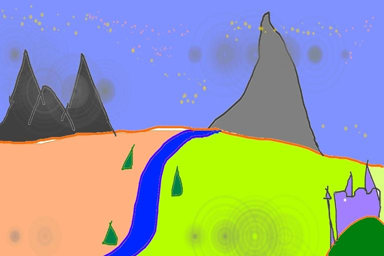

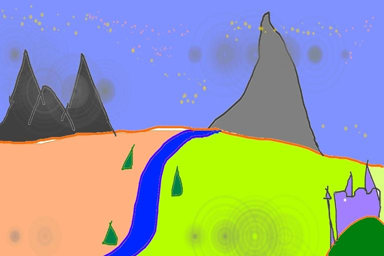

In [ ]:
#| server
im = PIL.Image.open("images/sketch-mountains-input.jpg")
display(im.resize((384, 256)))

b64 = pil_to_b64(im)
display(b64_to_pil(b64).resize((384, 256)))

## file_to_b64

In [ ]:
#| export
def file_to_b64(file_path: str) -> str:
    with open(file_path, "rb") as f:
        return base64.b64encode(f.read())

## b64_to_file

In [ ]:
#| export
def b64_to_file(b64, output_path):
    with open(output_path, "wb") as f:
        f.write(base64.b64decode(b64))

## convert_gif_to_mp4

In [ ]:
#| export
def convert_gif_to_mp4(gif_path: str, crf=25, mp4_dir="mp4") -> str:
    mp4_dir = os.path.join(os.path.dirname(gif_path), mp4_dir)
    gif_file = gif_path.split(os.path.sep)[-1]
    
    if not os.path.exists(mp4_dir):
        os.makedirs(mp4_dir)
        
    mp4_path = os.path.join(mp4_dir, gif_file.replace(".gif", ".mp4"))
    cmd = """
    ffmpeg -y -i {} -movflags faststart -pix_fmt yuv420p -vf \"scale=trunc(iw/2)*2:trunc(ih/2)*2\" 
    -crf {} -r 24 {}
    """
    os.system(cmd.format(gif_path, crf, mp4_path))
    return mp4_path

## [WIP] latents_to_animation

- non 512x512 image handling?

In [ ]:
#| export
def latents_to_animation(
    latents: Union[torch.Tensor, List[torch.Tensor]],
    frame_idx_to_ms: dict = None,
    ms_per_frame: int = 300,
    animation_fname="latent_animation",
) -> str:
    """
    Generate an animation file from give `latents` and return the path of the animation file
    
    - latents: shape of (#latents, channel, height, width)
    """
    ims = latents_to_pils(latents)
    first_im, rest_ims = ims[0], ims[1:]
    n = len(ims)
    durations = [ms_per_frame] * n
    for frame_idx, ms in frame_idx_to_ms.items():
        durations[frame_idx] = ms
    
    # save as gif
    gif_fpath = os.path.join(tempfile.tempdir, f"{animation_fname}.gif")
    first_im.save(
        gif_fpath,
        format="gif",
        save_all=True,
        duration=durations,
        append_images=rest_ims,
    )
    
    # make infinite loop and optim
    # https://github.com/kohler/gifsicle
    os.system(f"""
    convert -loop 0 {gif_fpath} {gif_fpath} \
        && gifsicle -O3 --lossy=35 -o {gif_fpath} {gif_fpath}
    """)
    
    return gif_fpath

In [ ]:
#| server
all_latents = pipe_out.all_latents
anim_path = latents_to_animation(all_latents)
IPythonImage(anim_path)

In [ ]:
#| server
all_latents_x0 = pipe_out.all_latents_x0
anim_path = latents_to_animation(all_latents_x0)
IPythonImage(anim_path)

In [ ]:
#| server
!ls -lh {anim_path}

-rw-rw-r-- 1 ec2-user ec2-user 1.1M Nov  4 15:52 /tmp/latent_animation.gif


# API models

## AIrtRequest

In [ ]:
#| export 
class Config:
    arbitrary_types_allowed = True

@pydantic.dataclasses.dataclass(config=Config)
class AIrtRequest:
    # inherit from `StableDiffusionPipeline`
    prompt: Union[str, List[str]]
    height: int = 512
    width: int = 512
    num_inference_steps: int = 30
    guidance_scale: float = 7.5
    negative_prompt: Union[List[str], str, None] = None
    num_images_per_prompt: Union[int, None] = 1
    eta: float = 0.0
        
    # inherif from `StableDiffusionImg2ImgPipeline`
    init_image: Union[torch.FloatTensor, PIL.Image.Image, str] = None # support b64
    strength: float = 0.6
    
    # custom parameters
    mode: str = None
    cmd: str = None
    animation_type: str = ""
    steps: int = 0
    cfg: float = None
    batch_size: int = None
    seed: int = None
    aspect_ratio: float = 1
    scheduler: str = "euler_a"
    
    # https://pydantic-docs.helpmanual.io/usage/validators/
    @pydantic.validator('steps')
    def steps_must_be_at_least_one(cls, v):
        if not v:
            return v
        
        if v < 1:
            raise ValueError("steps must be at least 1")
        return v
    
    
    @pydantic.validator('scheduler')
    def scheduler_must_be_available(cls, v):
        if v and not v in SCHEDULERS:
            raise ValueError(f"{v} is not a valid key in {SCHEDULERS.keys()}")
        return v.lower().strip()
    
    @pydantic.validator('animation_type')
    def animate_types_should_be_defined(cls, v):
        v = v.lower().strip().replace("-", "_")
        
        supported_animation_types =[
            "progress",
            "predict_x0"
        ]
        
        if v and not v in supported_animation_types:
            raise ValueError(f"{v} is not supported. Supported animation types: {supported_animation_types}")
        return v
    
    
    # https://pydantic-docs.helpmanual.io/usage/dataclasses/#initialize-hooks
    def __post_init_post_parse__(self, **kwargs):
        param_alias = {
            "steps": "num_inference_steps",
            "batch_size": "num_images_per_prompt",
            "cfg": "guidance_scale",
        }
        
        for custom_p, pipe_p in param_alias.items():
            custom_v = getattr(self, custom_p)
            pipe_v = getattr(self, pipe_p)
            
            if custom_v and custom_v != pipe_v:
                setattr(self, pipe_p, custom_v)
                
        # aspect ratio
        ar = self.aspect_ratio
        if ar != 1:
            width, height = get_image_size_from_aspect_ratio(ar)
            self.width = width
            self.height = height    
            
        # mode
        if self.init_image:
            self.mode = "image2image"
        else:
            self.mode = "text2image"
        
        # i2i image handling
        if isinstance(self.init_image, str):
            self.init_image = b64_to_pil(self.init_image)
            
        if isinstance(self.init_image, PIL.Image.Image):
            im = self.init_image
            w, h = im.size
            ar = round(w/h, 3)
            w, h = get_image_size_from_aspect_ratio(ar)
            
            self.width = w
            self.height = h
            self.aspect_ratio = ar
            self.init_image = im.resize((w, h))  # TODO: find the best resampling method
            

In [ ]:
#| server
req = AIrtRequest(
    prompt="handsome boy",
    init_image=b64,
    animation_type="progress",
)
req

AIrtRequest(prompt='handsome boy', height=512, width=512, num_inference_steps=30, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=<PIL.Image.Image image mode=RGB size=512x512>, strength=0.6, mode='image2image', cmd=None, animate='progress', steps=0, cfg=None, batch_size=None, seed=None, aspect_ratio=1.0, scheduler='euler_a')

## AIrtResponse

In [ ]:
#| export
@pydantic.dataclasses.dataclass
class AIrtResponse:
    seed: int
    images: List[str] = None
    animation: str = None

        
    def keys(self) -> dict:
        return self.__dict__.keys()

## get_pipe_params_from_airt_req

In [ ]:
#| export
def get_pipe_params_from_airt_req(req: AIrtRequest, pipe: StableDiffusionPipeline) -> dict:
    pipe_accepted_param_keys = inspect.signature(pipe).parameters.keys()
    pipe_params = {
        k: v for k, v in req.__dict__.items()
        if k in pipe_accepted_param_keys
    }
    return pipe_params

# Modes

- https://github.com/huggingface/diffusers/blob/main/docs/source/api/pipelines/stable_diffusion.mdx#tips

## text2image

In [ ]:
#| export
async def text2image(
    req: AIrtRequest, 
    return_pipe_out=False, 
    print_req=True
) -> Union[StableDiffusionPipelineOutput, AIrtResponse]:
    if print_req:
        pprint(req)
    
    generator = torch.Generator()
    seed = req.seed if req.seed else generator.seed()
    generator = torch.manual_seed(seed)
    
    scheduler_name = req.scheduler
    if scheduler_name:
        pipe.scheduler = SCHEDULERS[scheduler_name]
    
    pipe_params = get_pipe_params_from_airt_req(req, pipe)
    pipe_out = pipe(**pipe_params)
    torch.cuda.empty_cache()
    
    # set back to default scheduler
    pipe.scheduler = DEFAULT_SCHEDULER
        
    anim_b64 = None
    if req.animation_type:
        if req.animation_type == "progress":
            anim_path = latents_to_animation(
                pipe_out.all_latents,
                frame_idx_to_ms={-1: 2000},
                ms_per_frame=150,
            )
        elif req.animation_type == "predict-x0":
            anim_path = latents_to_animation(
                pipe_out.all_latents_x0,
                frame_idx_to_ms={-1: 2000},
                ms_per_frame=150,
            )
        else:
            raise NotImplementedError
            
        anim_b64 = file_to_b64(anim_path)

    ims_b64 = [pil_to_b64(im) for im in pipe_out.images]
    
    if return_pipe_out:
        return pipe_out
    else:
        return AIrtResponse(
            images=ims_b64,
            seed=seed,
            animation=anim_b64,
        )    

AIrtRequest(prompt='portrait of a girl, anime, perfect face, cyberpunk, art by wlop, symmetric, realistic, 8k, vivid', height=512, width=512, num_inference_steps=10, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=None, strength=0.6, mode='text2image', cmd=None, animate='', steps=10, cfg=7.5, batch_size=None, seed=16959009306137410145, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'diffusers.pipelines.stable_diffusion.StableDiffusionPipelineOutput'>
odict_keys(['images', 'text_input_ids', 'text_embeddings', 'uncond_embeddings', 'init_scaled_latents', 'all_latents', 'all_latents_x0'])


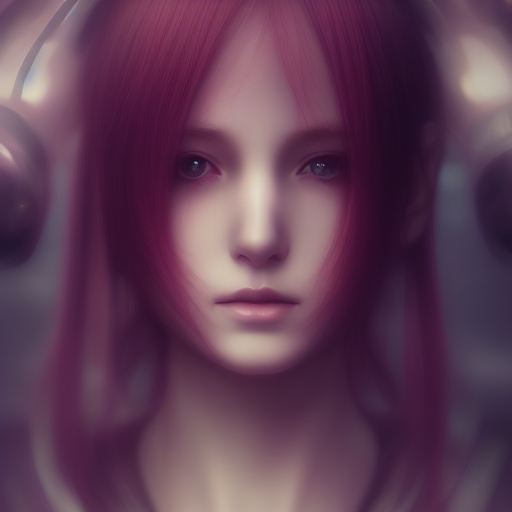

In [ ]:
#| server
req = AIrtRequest(
    prompt="portrait of a girl, anime, perfect face, cyberpunk, art by wlop, symmetric, realistic, 8k, vivid",
    seed=16959009306137410145,
    steps=10,
    cfg=7.5,    
#     aspect_ratio=0.5,
#     scheduler='euler_a'
)
task = text2image(req, return_pipe_out=True)
task_out = await task
print(type(task_out))
print(task_out.keys())
display(task_out['images'][0])

AIrtRequest(prompt='Cristiano Ronaldo flying in the sky with a jetpack', height=512, width=512, num_inference_steps=10, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=None, strength=0.6, mode='text2image', cmd=None, animate='', steps=10, cfg=7.5, batch_size=None, seed=3248208978774372251, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'diffusers.pipelines.stable_diffusion.StableDiffusionPipelineOutput'>
odict_keys(['images', 'text_input_ids', 'text_embeddings', 'uncond_embeddings', 'init_scaled_latents', 'all_latents', 'all_latents_x0'])


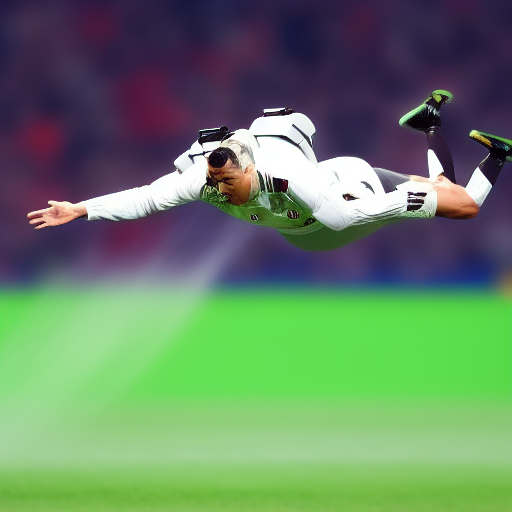

In [ ]:
#| server
req = AIrtRequest(
    prompt="Cristiano Ronaldo flying in the sky with a jetpack",
    seed=3248208978774372251,
    steps=10,
    cfg=7.5,    
)
task = text2image(req, return_pipe_out=True)
task_out = await task
print(type(task_out))
print(task_out.keys())
display(task_out['images'][0])

### T: API animation req

In [ ]:
#| server
req = AIrtRequest(
    prompt="Cristiano Ronaldo flying in the sky with a jetpack",
    seed=477776924,
    animation_type="progress"
)
task = text2image(req)
resp = await task
anim_b64 = resp.animation
path = os.path.join(tempfile.tempdir, "anim.gif")
b64_to_file(anim_b64, path)
display(IPythonImage(path))

In [ ]:
#| server
!ls -lh {path}

-rw-rw-r-- 1 ec2-user ec2-user 4.7M Nov  4 17:57 /tmp/anim.gif


## image2image

In [ ]:
#| export
async def image2image(
    req: AIrtRequest, 
    return_pipe_out=False,
    print_req=True
) -> Union[StableDiffusionPipelineOutput, AIrtResponse]:
    if print_req:
        pprint(req)
        
    generator = torch.Generator()
    seed = req.seed if req.seed else generator.seed()
    generator = torch.manual_seed(seed)
    
    scheduler_name = req.scheduler
    if scheduler_name:
        pipe.scheduler = SCHEDULERS[scheduler_name]
    
    pipe_params = get_pipe_params_from_airt_req(req, i2i_pipe)
    pipe_out = i2i_pipe(**pipe_params)
    torch.cuda.empty_cache()
    
    # set back to default scheduler
    pipe.scheduler = DEFAULT_SCHEDULER
    
    anim_b64 = None
    if req.animation_type:
        if req.animation_type == "progress":
            anim_path = latents_to_animation(
                [pipe_out.init_scaled_latents] + pipe_out.all_latents,
                frame_idx_to_ms={0: 2000, 1: 2000, -1: 2000}
            )
        elif req.animation_type == "predict_x0":
            anim_path = latents_to_animation(
                [pipe_out.init_scaled_latents] + pipe_out.all_latents_x0,
                frame_idx_to_ms={0: 2000, 1: 2000, -1: 2000}
            )
        else:
            raise NotImplementedError
        
        anim_b64 = file_to_b64(anim_path)

    ims_b64 = [pil_to_b64(im) for im in pipe_out.images]
    
    if return_pipe_out:
        pipe_out.animation = anim_b64
        return pipe_out
    else:
        return AIrtResponse(
            images=ims_b64,
            seed=seed,
            animation=anim_b64,
        )    

AIrtRequest(prompt='A fantasy landscape, trending on artstation', height=336, width=512, num_inference_steps=50, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=<PIL.Image.Image image mode=RGB size=512x336>, strength=0.75, mode='image2image', cmd=None, animate=None, steps=50, cfg=None, batch_size=None, seed=16959009306137410145, aspect_ratio=1.5, scheduler='euler_a')


  0%|          | 0/37 [00:00<?, ?it/s]

<class 'diffusers.pipelines.stable_diffusion.StableDiffusionPipelineOutput'>
odict_keys(['images', 'text_input_ids', 'text_embeddings', 'uncond_embeddings', 'init_scaled_latents', 'all_latents', 'all_latents_x0'])


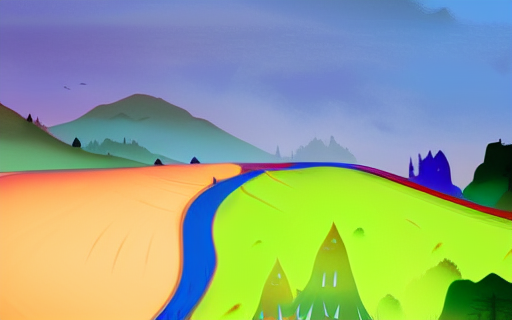

In [ ]:
#| server
req = AIrtRequest(
    prompt="A fantasy landscape, trending on artstation",
    seed=16959009306137410145,
    steps=50,
    strength=0.75,
    init_image=PIL.Image.open("images/sketch-mountains-input.jpg")
)
task = image2image(req, return_pipe_out=True)
task_out = await task
print(type(task_out))
print(task_out.keys())
display(task_out['images'][0])

### T: `init_image` as b64

AIrtRequest(prompt='handsome boy', height=512, width=512, num_inference_steps=10, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=<PIL.Image.Image image mode=RGB size=512x512>, strength=0.6, mode='image2image', cmd=None, animate='', steps=10, cfg=None, batch_size=None, seed=1627137983322845203, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/6 [00:00<?, ?it/s]

<class 'diffusers.pipelines.stable_diffusion.StableDiffusionPipelineOutput'>
odict_keys(['images', 'text_input_ids', 'text_embeddings', 'uncond_embeddings', 'init_scaled_latents', 'all_latents', 'all_latents_x0'])


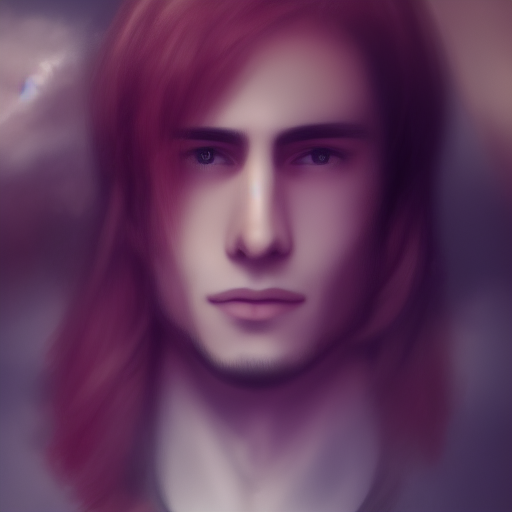

In [ ]:
#| server
im = PIL.Image.open("images/test_image.png")
b64 = pil_to_b64(im)

req = AIrtRequest(
    prompt="handsome boy",
    seed=1627137983322845203,
    steps=10,
    strength=0.6,
    init_image=b64,
)
task = image2image(req, return_pipe_out=True)
task_out = await task
print(type(task_out))
print(task_out.keys())
display(task_out['images'][0])

### T: animation: `predict_x0`

In [ ]:
#| server
im = PIL.Image.open("images/test_image.png")
b64 = pil_to_b64(im)

req = AIrtRequest(
    prompt="handsome boy",
    init_image=b64,
    animation_type="predict_x0",
    steps=30,
    strength=0.4
)
task = image2image(req, return_pipe_out=True)
resp = await task
anim_b64 = resp.animation
path = os.path.join(tempfile.tempdir, "anim.gif")
b64_to_file(anim_b64, path)
display(IPythonImage(path))

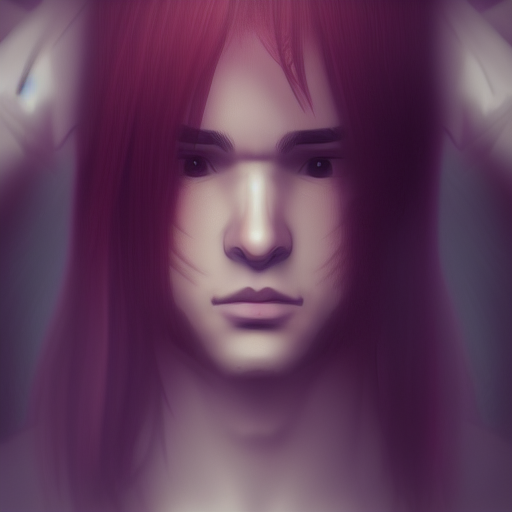

In [ ]:
#| server
resp.images[0]

### T: API animation req

In [ ]:
#| server
im = PIL.Image.open("images/test_image.png")
b64 = pil_to_b64(im)

req = AIrtRequest(
    prompt="handsome boy",
    init_image=b64,
    animation_type="progress",
    steps=30,
    strength=0.2
)
task = image2image(req)
resp = await task
anim_b64 = resp.animation
path = os.path.join(tempfile.tempdir, "anim.gif")
b64_to_file(anim_b64, path)
display(IPythonImage(path))

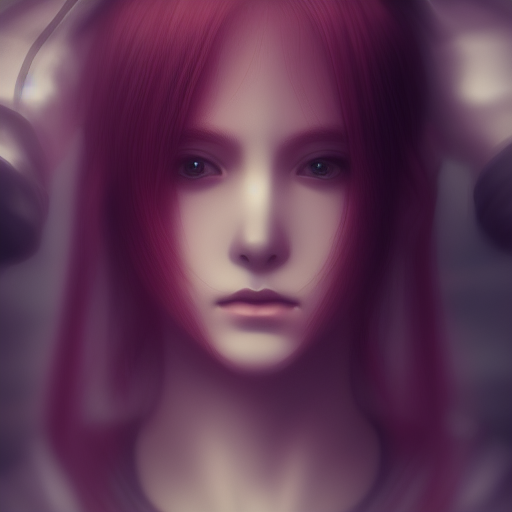

In [ ]:
#| server
b64_to_pil(resp.images[0])

# Pipeline callbacks

# API

## handle_airt_request

In [ ]:
#| export
async def handle_airt_request(req: AIrtRequest):
    pprint(req)
    mode = req.mode
    
    if mode == "text2image":
        return await text2image(req, print_req=False)
    elif mode == "image2image":
        return await image2image(req, print_req=False)
    else:
        raise NotImplementedError(req.mode)

### t2i

In [ ]:
#| server
req = AIrtRequest(
    prompt="portrait of a girl, anime, perfect face, cyberpunk, art by wlop, symmetric, realistic, 8k, vivid",
    seed=16959009306137410145,
    steps=10,
    cfg=7.5,    
)
task = handle_airt_request(req)
out = await task

AIrtRequest(prompt='portrait of a girl, anime, perfect face, cyberpunk, art by wlop, symmetric, realistic, 8k, vivid', height=512, width=512, num_inference_steps=10, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=None, strength=0.8, mode='text2image', cmd=None, steps=10, cfg=7.5, batch_size=None, seed=16959009306137410145, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#| server
req = AIrtRequest(
    prompt="Cristiano Ronaldo flying in the sky with a jetpack",
    seed=3248208978774372251,
    steps=10,
    cfg=7.5,    
)
task = handle_airt_request(req)
resp = await task
print(resp.keys())

AIrtRequest(prompt='Cristiano Ronaldo flying in the sky with a jetpack', height=512, width=512, num_inference_steps=10, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=None, strength=0.6, mode='text2image', cmd=None, animate='', steps=10, cfg=7.5, batch_size=None, seed=3248208978774372251, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['seed', 'images', 'animation', '__pydantic_initialised__'])

### i2i

AIrtRequest(prompt='A fantasy landscape, trending on artstation', height=512, width=512, num_inference_steps=50, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=<PIL.Image.Image image mode=RGB size=768x512>, strength=0.75, mode='image2image', cmd=None, steps=50, cfg=None, batch_size=None, seed=16959009306137410145, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/37 [00:00<?, ?it/s]

<class '__main__.AIrtResponse'>
dict_keys(['images', 'seed', '__pydantic_initialised__'])


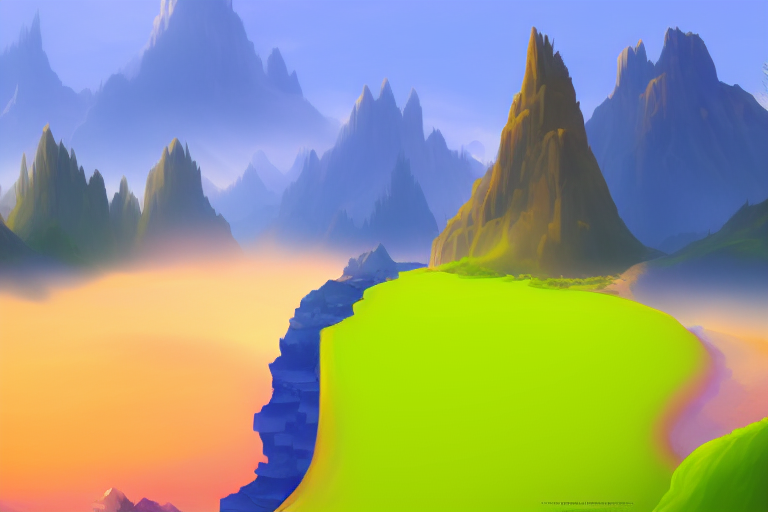

In [ ]:
#| server
im = PIL.Image.open("images/sketch-mountains-input.jpg")
b64 = pil_to_b64(im)

req = AIrtRequest(
    prompt="A fantasy landscape, trending on artstation",
    seed=16959009306137410145,
    steps=50,
    strength=0.75,
    init_image=b64,
    mode='image2image',
)
task = handle_airt_request(req)
task_out = await task
print(type(task_out))
print(task_out.keys())
b64 = task_out.images[0]
display(b64_to_pil(b64))

AIrtRequest(prompt='handsome boy', height=512, width=512, num_inference_steps=50, guidance_scale=7.5, negative_prompt=None, num_images_per_prompt=1, eta=0.0, init_image=<PIL.Image.Image image mode=RGB size=512x512>, strength=0.8, mode='image2image', cmd=None, steps=50, cfg=None, batch_size=None, seed=1627137983322845203, aspect_ratio=1.0, scheduler='euler_a')


  0%|          | 0/40 [00:00<?, ?it/s]

<class '__main__.AIrtResponse'>
dict_keys(['images', 'seed', '__pydantic_initialised__'])


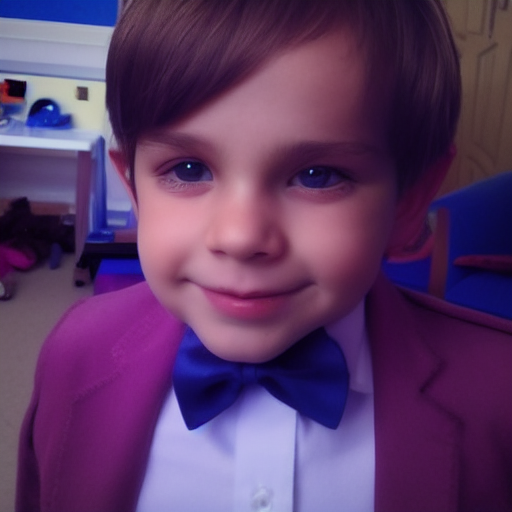

In [ ]:
#| server
im = PIL.Image.open("images/test_image.png")
b64 = pil_to_b64(im)

req = AIrtRequest(
    prompt="handsome boy",
    seed=1627137983322845203,
    steps=50,
    strength=0.8,
    init_image=b64,
    mode='image2image',
)
task = handle_airt_request(req)
task_out = await task
print(type(task_out))
print(task_out.keys())
b64 = task_out.images[0]
display(b64_to_pil(b64))

# export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()